# Visualizing SIR Models for COVID-19

Objectives: Look at the rate of COVID-19 growth by different regions and estimate the SIR curve.

In [119]:
import numpy as np
import pandas as pd
from importlib import reload
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy import optimize
import statsmodels.api as sm
import os
import pickle
import requests

from modeling import dataproc, optimizer, sir_model

# Load Covid-19 and Census Data

In [120]:
datastore = dataproc.DataStore()

# Utility functions

Functions that are called to plot the curve, etc.

In [154]:
def plot_sir_model(r, i, s, sim_days, plot_days, df, metric, sampling_rate, name):
    """Plot the model death rates and total deaths vs actual data.
    
    Args:
        r: Array holding daily recovered population values from SIR model
        i: Array holding daily infected population values from SIR model
        s: Array holding daily susceptible population values from SIR model
        total_model_days: Total number of modeled days to plot
        df: Dataframe holding metric values.
        metric: The type of metric to plot ('Cases' or 'Deaths')
        sampling_rate: Number of samples per day used to simulate the model.
        name: A name to attach to the plot.
    """
    start_time = df['Date'].min().timestamp()
    step_size = 24 * 60 * 60 / sampling_rate
    plot_end_time = start_time + plot_days * 24 * 60 * 60 
    sim_end_time = start_time + sim_days * 24 * 60 * 60 
    plot_timestamps = np.arange(start_time, plot_end_time, step_size)
    sim_timestamps = np.arange(start_time, sim_end_time, step_size)
    plot_dates = [datetime.utcfromtimestamp(x) for x in plot_timestamps]
    sim_dates = [datetime.utcfromtimestamp(x) for x in sim_timestamps]
    print('peak infection rate date', sim_dates[np.argmax(i * s)])
    # Plot peak infection
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.ticklabel_format(useOffset=False)
    ax.ticklabel_format(style='plain')
    ax.plot(plot_dates[:-sampling_rate],
            (r[sampling_rate:len(plot_dates)] + i[sampling_rate:len(plot_dates)]
             - r[:len(plot_dates)-sampling_rate] - i[:len(plot_dates)-sampling_rate]),
            c='g',
            label='model ' + metric + ' rate',
            linewidth=4)
    ax.plot(df['Date'].to_list()[:-1],
            (df[metric] - df[metric].shift())[1:], label='actual ' + metric + ' rate', c='r', linewidth=4)
    ax.set_title('SIR model for ' + name)
    ax.set_xlabel('Number of days')
    ax.set_ylabel('Number of individuals')
    plt.legend()
    plt.plot()
    
    # Plot recovery
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.ticklabel_format(useOffset=False)
    ax.ticklabel_format(style='plain')
    ax.plot(plot_dates, r[:len(plot_dates)] + i[:len(plot_dates)], c='g',
            label='model ' + metric, linewidth=4)
    ax.plot(df['Date'].to_list(), df[metric], label='actual ' + metric, c='r', linewidth=4)
    ax.set_title('SIR model for ' + name)
    ax.set_xlabel('Number of days')
    ax.set_ylabel('Number of individuals')
    plt.legend()
    plt.show()

## Modeling parameters



In [122]:
SIMULATION_DAYS = 360 # Total number of days to simulate when plotting forecast model.
SAMPLING_RATE = 10 # Modeling time samples per day

## Looking up FIPS for states and counties to model

Use the following query to obtain state and county FIPS of interest. This can be used in the below AREA_OF_INTEREST assignment, or you can also use one of the folowing regions of interest below

### Regions of interest

Some interesting areas (Name, State FIPS, County FIPS) below. Copy one of the values in the bullet points into AREA_OF_INTEREST below.
* ('US', 'NYC', 36, [5, 47, 61, 81, 85])
* ('US', 'New Orleans', 22, [51, 71, 75, 87, 89, 95, 103, 105])
* ('US', 'Detroit', 26, [87, 93, 99, 125, 147, 163])
* ('US', 'Bay Area, CA', 6, [1, 13, 41, 55, 75, 81, 85, 95, 97])
* ('US', 'Greater LA Area, CA', 6, [37, 59, 65, 71, 111])
* ('US', 'Chicago', 17, [31, 37, 43, 63, 89, 91, 93, 111, 197])
* ('US', 'Houston', 48, [15, 39, 71, 157, 167, 201, 291, 339, 473])
* ('US', 'Austin', 48, [209, 453, 491])
* ('US', 'Miami', 12, [11, 86, 99])
* ('US', 'Tampa-St. Petersburg', 12, [53, 57, 101, 103])

If County FIPS is empty, this will fetch stats for the whole state:
* ('US', 'Alabama', 1 , [])
* ('US', 'Arizona', 4, [])
* ('US', 'California', 6, [])
* ('US', 'Florida', 12, [])
* ('US', 'Georgia', 13, [])
* ('US', 'Iowa', 19, [])
* ('US', 'Michigan', 26, [])
* ('US', 'New Jersey', 34, [])
* ('US', 'New Mexico', 35, [])
* ('US', 'New York', 36, [])
* ('US', 'Texas', 48, [])
* ('US', 'Utah', 49, []) 
* ('US', 'Washington', 53, [])

If Country is not US, this will fetch a country's total stats:
* ('Italy', 'Italy')
* ('Spain', 'Spain')
* ('United Kingdom', 'United Kingdom')
* ('US', 'US')
* ('Germany', 'Germany')

In [123]:
# Example on looking up state and county FIPS

lookup_df = datastore.county_census_df[(datastore.county_census_df.STNAME == 'Missouri')
#                             & (datastore.county_census_df.CTYNAME.isin([
#                                  'Travis County',
#                                  'Hays County',
#                                  'Williamson County',
#                             ]))
]
print('state fips', lookup_df['STATE'].iloc[0])
print('county fips', lookup_df['COUNTY'].tolist())
lookup_df


state fips 29
county fips [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 186, 187, 189, 195, 197, 199, 201, 203, 205, 207, 209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 510]


,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
1508,40,2,4,29,0,Missouri,Missouri,5988927,5988950,5995974,...,-0.115833,-0.993982,-0.889266,-0.154827,-0.458795,0.122692,-0.033720,1.182732,0.500152,0.781953
1509,50,2,4,29,1,Missouri,Adair County,25607,25606,25625,...,-12.082095,-0.273000,-1.363672,0.856398,-8.472591,-8.452255,-6.403542,5.525625,-0.039289,-8.185915
1510,50,2,4,29,3,Missouri,Andrew County,17291,17296,17344,...,1.356929,-10.421793,5.737467,-0.288884,-3.353861,-0.231241,2.769364,5.283561,8.936703,1.243851
1511,50,2,4,29,5,Missouri,Atchison County,5685,5683,5656,...,-2.130544,-9.439843,-4.329785,-15.546411,-8.164023,-5.444987,0.567322,-3.230711,-9.399578,-1.743173
1512,50,2,4,29,7,Missouri,Audrain County,25529,25531,25453,...,-2.991478,-0.313849,-1.684590,-0.391627,8.060591,3.399915,-4.399846,-11.737272,-7.566699,-2.834032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,50,2,4,29,223,Missouri,Wayne County,13521,13535,13519,...,-13.843492,-3.117577,3.354079,5.877320,5.935599,0.445898,-11.849852,10.701232,-8.927558,-13.997308
1620,50,2,4,29,225,Missouri,Webster County,36202,36264,36320,...,5.535032,-1.704046,-6.612160,0.492651,4.208069,9.136457,8.025555,9.701036,5.749192,5.535032
1621,50,2,4,29,227,Missouri,Worth County,2171,2169,2152,...,-8.913097,-6.088993,-19.533111,1.923539,-7.742560,-2.929688,-4.929751,16.272189,-4.917630,-8.913097
1622,50,2,4,29,229,Missouri,Wright County,18815,18742,18779,...,6.086194,-10.816310,-2.477914,-12.957792,-8.102707,-4.017169,0.770692,2.198104,-0.109899,5.702380


In [192]:
AREA_OF_INTEREST = ('US', 'Georgia', 13, [])
MODEL_FIT_LAST_DATE = datetime(2020, 6, 15)  # Fit model to data before this date, reserving later dates as holdout.
MODEL_FIT_FIRST_DATE = MODEL_FIT_LAST_DATE - timedelta(27)#'2020-04-25'
METRIC = 'Deaths'
pop_frac = 0.01
# METRIC = 'Cases'
# pop_frac = 0.25

Total population 10617423


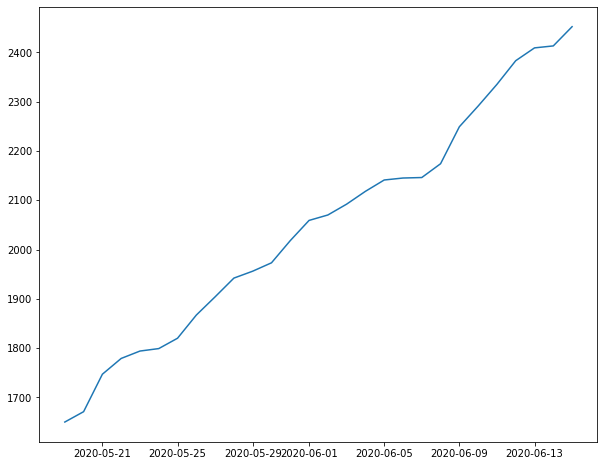

10617423


,Date,Deaths
0,2020-05-19,1650
1,2020-05-20,1671
2,2020-05-21,1747
3,2020-05-22,1779
4,2020-05-23,1794
5,2020-05-24,1799
6,2020-05-25,1820
7,2020-05-26,1867
8,2020-05-27,1904
9,2020-05-28,1942


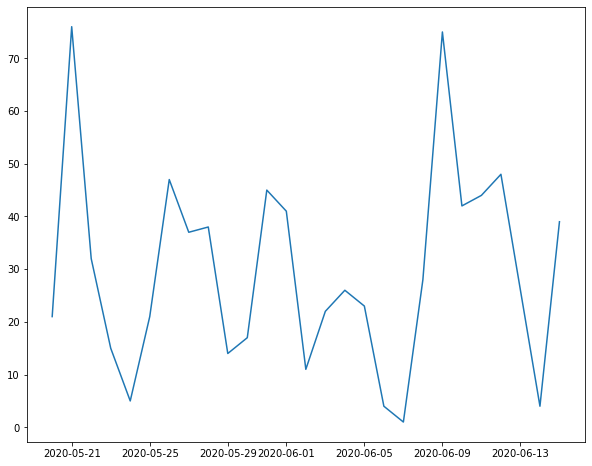

In [193]:
if len(AREA_OF_INTEREST) <= 2:
    area_df, population = datastore.get_time_series_for_area(AREA_OF_INTEREST[0])
else:
    area_df, population = datastore.get_time_series_for_area(
        AREA_OF_INTEREST[0], AREA_OF_INTEREST[2], AREA_OF_INTEREST[3])

area_df = area_df[['Date', METRIC]]
train_area_df = area_df[
    (area_df.Date >= MODEL_FIT_FIRST_DATE) & 
    (area_df.Date <= MODEL_FIT_LAST_DATE)][['Date', METRIC]]
train_area_df = train_area_df[train_area_df[METRIC] > 0]
train_area_df = train_area_df.sort_values(by=['Date']).reset_index(drop=True)
# Validate selection through plot and inspection
plt.figure(figsize=(10, 8))
plt.plot(train_area_df['Date'], train_area_df[METRIC])
plt.show()
plt.figure(figsize=(10, 8))
plt.plot(train_area_df['Date'], (train_area_df[['Date', METRIC]]-train_area_df[['Date', METRIC]].shift(1))[METRIC])
print(population)
train_area_df

dow
0    1.099594
1    1.132008
2    1.035932
3    1.292106
4    0.979057
5    0.509431
6    0.778820
dtype: float64


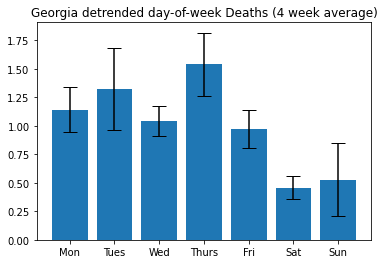

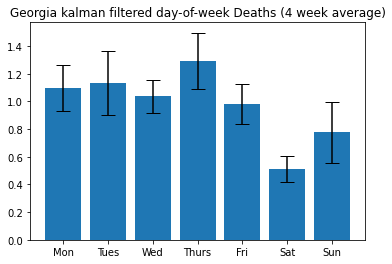

/Users/bfoo/env3/general/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


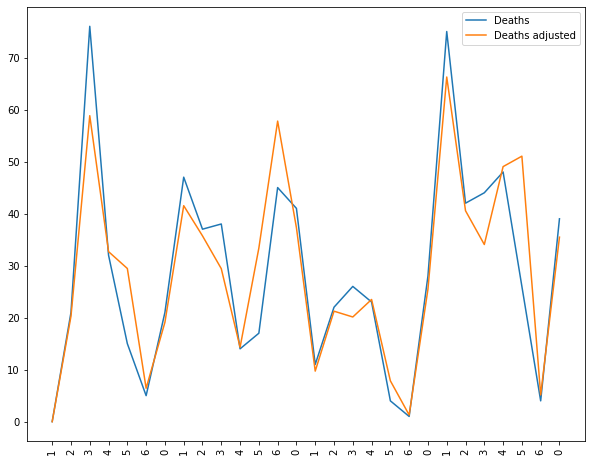

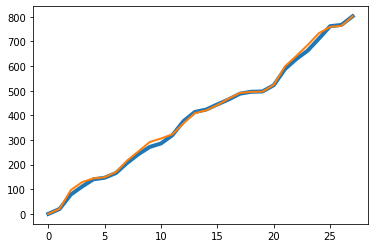

In [194]:
# Detrend by day of week
DAYS_OF_THE_WEEK = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

area_df['dow'] = area_df['Date'].dt.dayofweek
area_df[METRIC + ' diff'] = area_df[METRIC] - area_df[METRIC].shift(1)
area_df[METRIC + ' Squared diff'] = area_df[METRIC + ' diff'] * area_df[METRIC + ' diff']
dow_sum = None
weeks = 4

weekly_sum = 0
weekly_sum_squared = 0
for days_before in range(weeks*7-1, weeks*7+6): #7 days shift
    for week in range(weeks):
        start_date = area_df['Date'].max() + timedelta(-days_before+week*7)
        norm_dow = area_df[
            (area_df['Date'] >= start_date) &
            (area_df['Date'] <= start_date + timedelta(6))
        ][['Date', METRIC, METRIC + ' diff', METRIC + ' Squared diff', 'dow']].groupby('dow').sum()
        dow_mean = norm_dow[METRIC + ' diff'].mean()
        norm_dow[METRIC + ' diff'] /= (dow_mean + 1e-4)
        norm_dow[METRIC + ' diff'] = np.maximum(norm_dow[METRIC + ' diff'], 1e-4)
        norm_dow[METRIC + ' Squared diff'] /= ((dow_mean + 1e-4) ** 2)
        norm_dow[METRIC + ' Squared diff'] = np.maximum(norm_dow[METRIC + ' Squared diff'], 1e-8)
        weekly_sum += norm_dow[METRIC + ' diff'].sum()
        weekly_sum_squared += norm_dow[METRIC + ' Squared diff'].sum()
        if dow_sum is None: # 1 week of data
            dow_sum = norm_dow
        else:
            dow_sum += norm_dow
            
# Total number of samples is weeks * 7, so we take the mean by dividing by weeks * 7
death_mean = dow_sum[METRIC + ' diff'] / weeks / 7
death_err = np.sqrt(dow_sum[METRIC + ' Squared diff'] / weeks / 7 - death_mean * death_mean) / np.sqrt(weeks)
weekly_mean = weekly_sum / weeks / 7 / 7
weekly_err = np.sqrt(weekly_sum_squared / weeks / 7 / 7 - weekly_mean * weekly_mean) / np.sqrt(weeks)
# Apply Gaussian weighted averaging
kf_mean = (death_mean * (1 / death_err ** 2) + weekly_mean * (1 / weekly_err ** 2)
                         ) / ((1 / death_err ** 2) + (1 / weekly_err ** 2))
kf_err = np.sqrt(1 / ((1 / death_err ** 2) + (1 / weekly_err ** 2)))
print(kf_mean)
plt.bar(DAYS_OF_THE_WEEK, death_mean, yerr=death_err, capsize=7)
plt.title(AREA_OF_INTEREST[1] + ' detrended day-of-week ' + METRIC + ' (' + str(weeks) + ' week average)')
plt.show()

plt.bar(DAYS_OF_THE_WEEK, kf_mean, yerr=kf_err, capsize=7)
plt.title(AREA_OF_INTEREST[1] + ' kalman filtered day-of-week ' + METRIC + ' (' + str(weeks) + ' week average)')
plt.show()

diff_df = train_area_df-train_area_df.shift(1)
diff_df['Date'] = train_area_df['Date']
diff_df['dow'] = diff_df['Date'].dt.dayofweek

diff_df[METRIC + ' adjusted'] = diff_df[METRIC] / (diff_df['dow'].apply(lambda x: kf_mean[x]) + 1e-8)
diff_df[METRIC].iloc[0] = 0
diff_df[METRIC + ' adjusted'].iloc[0] = 0

plt.figure(figsize=(10, 8))
plt.plot(diff_df['Date'], diff_df[METRIC], label=METRIC)
plt.plot(diff_df['Date'], diff_df[METRIC + ' adjusted'], label=METRIC + ' adjusted')
plt.xticks(diff_df['Date'], diff_df['dow'], rotation='vertical')
plt.legend()
plt.show()

diff_df[METRIC + ' cumsum'] = diff_df[METRIC].cumsum()
diff_df[METRIC + ' adjusted cumsum'] = diff_df[METRIC + ' adjusted'].cumsum()
plt.plot(diff_df[METRIC + ' adjusted cumsum'] * diff_df[METRIC + ' cumsum'].iloc[-1] / diff_df[METRIC + ' adjusted cumsum'].iloc[-1],
         linewidth=4)
plt.plot(diff_df[METRIC + ' cumsum'], linewidth=2)

#train_area_df[METRIC + ' adjusted'] = train_area_df[METRIC].iloc[0] + diff_df[METRIC + ' adjusted cumsum'] * diff_df[METRIC + ' cumsum'].iloc[-1] / diff_df[METRIC + ' adjusted cumsum'].iloc[-1]
train_area_df[METRIC + ' adjusted'] = train_area_df[METRIC]

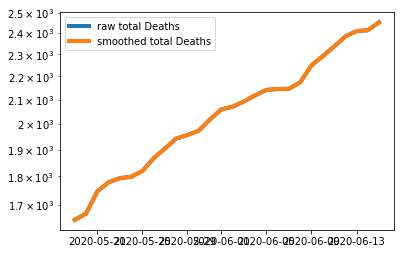

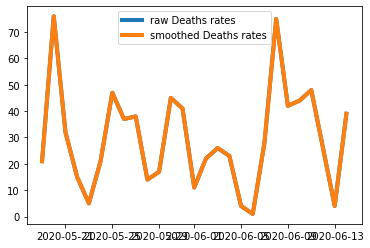

In [195]:
# Optional: Get rid of single day outliers by using a window to limit the outlier slope
# to the second largest/smallest slope
# Rescale to keep the total number of deaths equal.


train_data = dataproc.convert_data_to_numpy(train_area_df, METRIC + ' adjusted', smooth=False)
plt.yscale('log')
plt.plot(train_area_df['Date'], train_area_df[METRIC], linewidth=4, label='raw total ' + METRIC)
plt.plot(train_area_df['Date'], train_data, linewidth=4, label='smoothed total ' + METRIC)
plt.legend()
plt.show()

plt.plot(train_area_df['Date'].iloc[:-1],
         train_area_df[METRIC].iloc[1:].to_numpy() - train_area_df[METRIC].iloc[:-1].to_numpy(),
         linewidth=4, label='raw ' + METRIC + ' rates')
plt.plot(train_area_df['Date'].iloc[:-1],
         train_data[1:] - train_data[:-1],
         linewidth=4, label='smoothed ' + METRIC + ' rates')
plt.legend()

## Fitting Values to the Model

We try to find the best fit of all parameters of the model by minimizing its mean squared error (mse) from actual data points.

Note that the simple algorithm used below is randomized and not guaranteed to be optimal, but in practice, seems to converge to a near optimal solution quickly. Also, approaches such as Bayesian optimization, annealing, and other guaranteed optimal techniques take a long time to run per iteration and have occasionally stalled the notebook.

In [196]:

reload(sir_model)
reload(optimizer)
# Reasonable search regions for each parameter
recovery_days = 10.0 # This is fairly constant

infection_rate_range = [0.001, 0.80]
multiplier_range = [0.01, 10.0]
frac_infected_range = [0.01, 0.99]

best_param, best_value = optimizer.minimize(
    train_data, population, recovery_days,
    pop_frac, infection_rate_range, multiplier_range, frac_infected_range
)
print('Param', best_param)
print('MSE', best_value)

Param [0.10880021 1.01611684 0.1448568 ]
MSE 528.9416312865703


Population fraction susceptible (e.g. would die if infected): 0.01
Population susceptible (e.g. would die if infected): 106174.23
Fraction of infected/recovered population currently infected at start of simulation: 0.1448568033367538
Final population affected (e.g. dead) since start of simulation: 13702.55223890119
Final population affected (e.g. dead) overall: 15352.55223890119
Current and final herd immunity level: 0.02309411615229044 0.14484818985975118
Transmissions per person per day: 0.10880021439439276
First day estimate multiplier 1.0161168402131489
R0 (initial transmit rate / recovery rate) 1.0880021439439276
R (current transmit rate / recovery rate) 1.0628756960577455
Training MSE 528.9416312865703
Validation MSE 517.8709606090407
[ 1676.59278635  1679.19344644  1681.79588358 ... 15374.87883087
 15377.01269516 15379.14502525]
peak infection rate date 2020-10-29 12:00:00


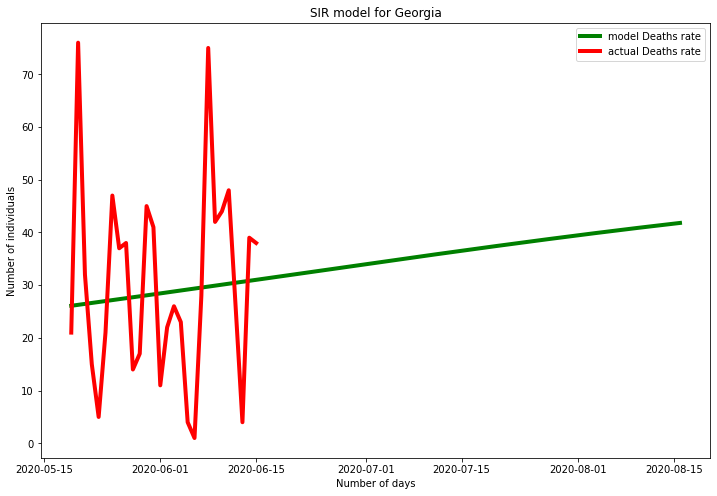

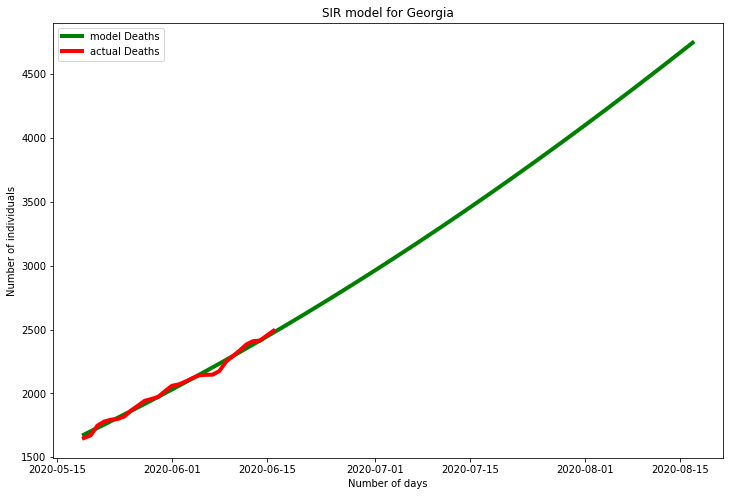

([datetime.datetime(2020, 5, 19, 0, 0),
  datetime.datetime(2020, 5, 19, 2, 24),
  datetime.datetime(2020, 5, 19, 4, 48),
  datetime.datetime(2020, 5, 19, 7, 12),
  datetime.datetime(2020, 5, 19, 9, 36),
  datetime.datetime(2020, 5, 19, 12, 0),
  datetime.datetime(2020, 5, 19, 14, 24),
  datetime.datetime(2020, 5, 19, 16, 48),
  datetime.datetime(2020, 5, 19, 19, 12),
  datetime.datetime(2020, 5, 19, 21, 36),
  datetime.datetime(2020, 5, 20, 0, 0),
  datetime.datetime(2020, 5, 20, 2, 24),
  datetime.datetime(2020, 5, 20, 4, 48),
  datetime.datetime(2020, 5, 20, 7, 12),
  datetime.datetime(2020, 5, 20, 9, 36),
  datetime.datetime(2020, 5, 20, 12, 0),
  datetime.datetime(2020, 5, 20, 14, 24),
  datetime.datetime(2020, 5, 20, 16, 48),
  datetime.datetime(2020, 5, 20, 19, 12),
  datetime.datetime(2020, 5, 20, 21, 36),
  datetime.datetime(2020, 5, 21, 0, 0),
  datetime.datetime(2020, 5, 21, 2, 24),
  datetime.datetime(2020, 5, 21, 4, 48),
  datetime.datetime(2020, 5, 21, 7, 12),
  datetime.

In [197]:
#Validation plot
validation_area_df = area_df # TODO: add holdout days
validation_area_df = validation_area_df[
    (validation_area_df.Date >= MODEL_FIT_FIRST_DATE)
    #& (validation_area_df.Date <= MODEL_FIT_LAST_DATE)
]
validation_area_df = validation_area_df[validation_area_df[METRIC] > 0]
validation_area_df = validation_area_df.sort_values(by=['Date']).reset_index(drop=True)

best_infection_rate = best_param[0]
best_multiplier = best_param[1]
best_frac_infected = best_param[2]

infected = train_data[0] * best_multiplier * best_frac_infected
recovered = train_data[0] * best_multiplier * (1 - best_frac_infected)
t, s, i, r = sir_model.compute_sir(
    SAMPLING_RATE,
    SIMULATION_DAYS,
    population * pop_frac,
    infected,
    recovered,
    best_infection_rate,
    recovery_days
)

valid_obj = sir_model.create_objective_fn(
    validation_area_df[METRIC].to_numpy(), population, sampling_rate=SAMPLING_RATE)

validation_mse = valid_obj(pop_frac, best_infection_rate, recovery_days, best_multiplier, best_frac_infected)

print('Population fraction susceptible (e.g. would die if infected):', pop_frac)
print('Population susceptible (e.g. would die if infected):', pop_frac * population)
print('Fraction of infected/recovered population currently infected at start of simulation:', best_frac_infected)
print('Final population affected (e.g. dead) since start of simulation:', (s[0] - s[-1]))
print('Final population affected (e.g. dead) overall:', (train_area_df[METRIC].iloc[0] + s[0] - s[-1]))
print('Current and final herd immunity level:',
      train_data[-1] / pop_frac / population,
      (population * pop_frac - s[-1]) / pop_frac / population)
print('Transmissions per person per day:', best_infection_rate)
print('First day estimate multiplier', best_multiplier)
print('R0 (initial transmit rate / recovery rate)', best_infection_rate * recovery_days)
print('R (current transmit rate / recovery rate)', best_infection_rate * recovery_days * (1 - train_data[-1] / pop_frac / population))
print('Training MSE', best_value)
print('Validation MSE', validation_mse)
print(r + i)
plot_sir_model(r, i, s, SIMULATION_DAYS, 90, validation_area_df, METRIC, SAMPLING_RATE, AREA_OF_INTEREST[1])

In [161]:
step_size = 24 * 60 * 60 / SAMPLING_RATE
start_time = validation_area_df['Date'].min().timestamp()
sim_end_time = start_time + SIMULATION_DAYS * 86400
sim_timestamps = np.arange(start_time, sim_end_time, step_size)
sim_dates = [datetime.utcfromtimestamp(x) for x in sim_timestamps]
list(zip(sim_dates, r + i))

[(datetime.datetime(2020, 5, 19, 0, 0), 2479.1617302385753),
 (datetime.datetime(2020, 5, 19, 2, 24), 2484.1230845665114),
 (datetime.datetime(2020, 5, 19, 4, 48), 2489.0851222262754),
 (datetime.datetime(2020, 5, 19, 7, 12), 2494.047841934764),
 (datetime.datetime(2020, 5, 19, 9, 36), 2499.0112424081663),
 (datetime.datetime(2020, 5, 19, 12, 0), 2503.9753223619628),
 (datetime.datetime(2020, 5, 19, 14, 24), 2508.940080510929),
 (datetime.datetime(2020, 5, 19, 16, 48), 2513.9055155691326),
 (datetime.datetime(2020, 5, 19, 19, 12), 2518.871626249939),
 (datetime.datetime(2020, 5, 19, 21, 36), 2523.8384112660096),
 (datetime.datetime(2020, 5, 20, 0, 0), 2528.8058693293056),
 (datetime.datetime(2020, 5, 20, 2, 24), 2533.7739991510875),
 (datetime.datetime(2020, 5, 20, 4, 48), 2538.7427994419168),
 (datetime.datetime(2020, 5, 20, 7, 12), 2543.712268911657),
 (datetime.datetime(2020, 5, 20, 9, 36), 2548.6824062694755),
 (datetime.datetime(2020, 5, 20, 12, 0), 2553.6532102238457),
 (datetime